<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Binary-Classification/ML_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [1]:
!pip install matplotlib==3.1.0

In [2]:
!pip install hazm
!pip install stopwords_guilannlp

     |████████████████████████████████| 317kB 9.3MB/s 
     |████████████████████████████████| 1.4MB 75.0MB/s 
     |████████████████████████████████| 235kB 74.4MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394470 sha256=66a420417e04fc91dadfafda49772a3bc806a7dde8fb544befcf3825ab2244ea
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154527 sha256=d964e91827c5a08364fdc349e19cda7063859d566daba4e2b22eb74cba85fd7f
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## Import Libraries

In [0]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# sklearn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
# Measuring metrics
from sklearn.metrics import f1_score

# Upload dataset files

Upload dataset files to colab environment

In [4]:
uploaded = files.upload()

Saving balanced.csv to balanced.csv
Saving original.csv to original.csv
Saving test.csv to test.csv
Saving translation.csv to translation.csv



# Import & Analyze Dataset

In [0]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [0]:
x_test = test[0]
y_test = test[1]

In [7]:
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [0]:
binary_y_test = []
binary_x_test = []
for i, y in enumerate(y_test):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_test.append(1)
      binary_x_test.append(x_test[i])
    else:
      binary_y_test.append(0)
      binary_x_test.append(x_test[i])

In [0]:
x_test = np.asarray(binary_x_test)
y_test = np.asarray(binary_y_test)

In [0]:
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [0]:
selected_dataset = original

In [0]:
selected_dataset = selected_dataset.sample(frac=1).reset_index(drop=True)

In [0]:
x_train = selected_dataset[0]
y_train = selected_dataset[1]

In [152]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (5561,)
Number of training label:  (5561,)


In [0]:
binary_y_train = []
binary_x_train = []
for i, y in enumerate(y_train):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_train.append(1)
      binary_x_train.append(x_train[i])
    else:
      binary_y_train.append(0)
      binary_x_train.append(x_train[i])

In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(binary_x_train)
y_train = np.asarray(binary_y_train)

In [155]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{0: 541, 1: 2611}


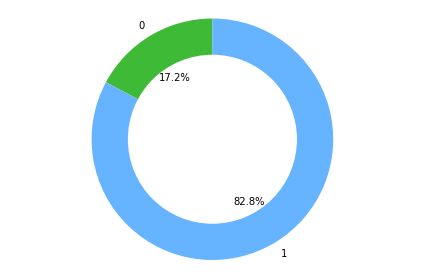

In [156]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('distribution.png')

# Preprocess

In [0]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

# Machine Learning Algorithms

In [0]:
# Make stop word set
stop_set = stopwords_output("Persian", "set")


# When building the vocabulary ignore terms that have a document frequency strictly lower than
# the given threshold. This value is also called cut-off in the literature.
min_df = 1


# Tokenize function used in Vectorizer
def tokenize(text):
    return word_tokenize(text)

## Naive Bayes

In [173]:
# (Multinomial) Naive Bayes Model
naive_bayes = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                              analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                     ('tfidf', TfidfTransformer(sublinear_tf=True)),
                     ('clf', MultinomialNB())])
naive_bayes = naive_bayes.fit(x_train, y_train)
naive_score = naive_bayes.score(x_test, y_test)
print('Naive Bayes Model: ', naive_score)
predict_nb = naive_bayes.predict(x_test)

Naive Bayes Model:  0.8235823582358236


## Support Vector Machine

In [204]:
# Linear Support Vector Machine Model
svm = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                         analyzer='word', ngram_range=(1, 2),
                                                         min_df=min_df, lowercase=False)),
                                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                                ('clf-svm', LinearSVC(loss='hinge', penalty='l2',
                                                      max_iter=5))])

svm = svm.fit(x_train, y_train)
linear_svc_score = svm.score(x_test, y_test)
print('Linear SVC Model: ', linear_svc_score)
predict_svm = svm.predict(x_test)

Linear SVC Model:  0.8631863186318632


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Stochastic Gradient Descent

In [205]:
# SGD (Stochastic Gradient Descent) Model
sgd = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                  analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                         ('tfidf', TfidfTransformer(sublinear_tf=True)),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, max_iter=5))])
sgd = sgd.fit(x_train, y_train)
sgd_score = sgd.score(x_test, y_test)
print('SGD Model: ', sgd_score)
predict_sgd = sgd.predict(x_test)

SGD Model:  0.8226822682268227


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


# Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1])
np.set_printoptions(precision=2)

In [0]:
y_test = y_test.astype(int)
predict_nb = predict_nb.astype(int)
predict_svm = predict_svm.astype(int)
predict_sgd = predict_sgd.astype(int)

Confusion matrix, without normalization
[[  0 196]
 [  0 915]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]
AxesImage(54,36;334.8x217.44)


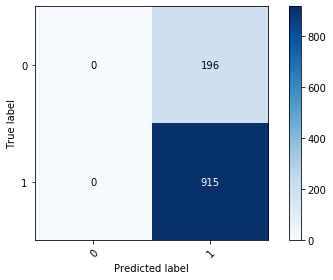

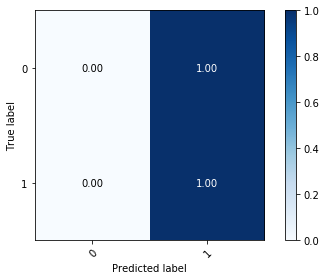

In [208]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names)
# plt.savefig('cm-nb.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names, normalize=True)
# plt.savefig('cm-nb-normalized.png')
plt.show()

Confusion matrix, without normalization
[[ 55 141]
 [ 11 904]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.28 0.72]
 [0.01 0.99]]
AxesImage(54,36;334.8x217.44)


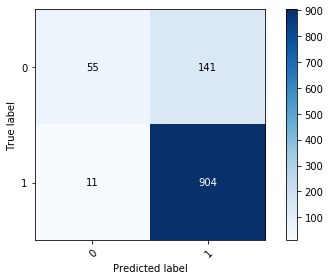

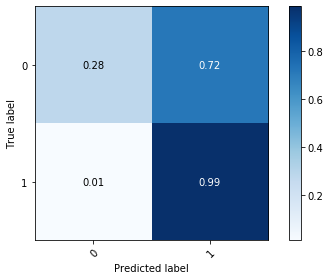

In [209]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names)
# plt.savefig('cm-svm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names, normalize=True)
# plt.savefig('cm-svm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[  0 196]
 [  1 914]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]
AxesImage(54,36;334.8x217.44)


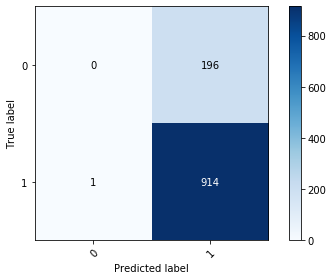

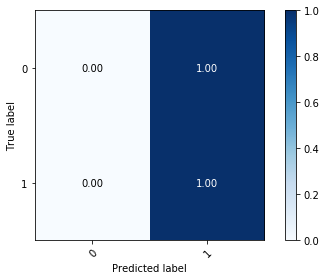

In [210]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names)
# plt.savefig('cm-sgd.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names, normalize=True)
# plt.savefig('cm-sgd-normalized.png')
plt.show()

## F1 Score

In [211]:
print("F1 score of NB model:")
f1_score(y_test, predict_nb, average='weighted')

F1 score of NB model:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7439070659287054

In [212]:
print("F1 score of SVM model:")
f1_score(y_test, predict_svm, average='weighted')

F1 score of SVM model:


0.8337811815143191

In [213]:
print("F1 score of SGD model:")
f1_score(y_test, predict_sgd, average='weighted')

F1 score of SGD model:


0.7434610127679435